### - Sobhan Moradian Daghigh
#### - 5/20/2022
#### - ANN - HW05

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import urllib
import tensorflow as tf, keras
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers.merge import concatenate

import warnings
warnings.filterwarnings("ignore")

import itertools

%load_ext tensorboard

In [2]:
print(tf.__version__)

2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
tb_callback = keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/logs', histogram_freq=1)

In [5]:
class EarlyStoppingCallback(keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = 0
    self.wait = 0
  
  def on_epoch_end(self, epoch, logs=None):
    current_acc = logs.get('accuracy')
    if np.less(self.best, current_acc):
      self.best = current_acc
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if np.greater_equal(self.wait, self.patience):
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

In [6]:
es_callback = EarlyStoppingCallback(patience=3)

# Load Data

In [7]:
def load_data(base_url, names):
  datas = []
  labels = []
  for name in names:
    file = urllib.request.urlopen(base_url + '{}.data'.format(name))
    while True:
      # Reading label
      label = file.readline().decode("utf-8").strip()

      # EOF
      if label is '':
        break

      label = 1 if label in ['normal', 'ok'] else 0
      labels.append(label)

      # Packing each 15 datas
      pack = []
      for _ in range(15):
        data = [np.float64(x) for x in (file.readline().decode("utf-8")[:-1].split('\t')[1:])]
        pack.append(data)
      datas.append(pack)

      # Skipping for two empty lines
      file.readline()
      file.readline()

  return np.array(datas), np.array(labels)

In [8]:
base_url = 'https://raw.githubusercontent.com/nahbos/AUT-Neural-Networks/main/HW05/data/'
names = ['lp1', 'lp2', 'lp3', 'lp4', 'lp5']
datas, labels = load_data(base_url, names)

In [9]:
datas.shape

(463, 15, 6)

In [10]:
x_temp, x_test, y_temp, y_test = train_test_split(datas, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.125, random_state=42)

In [11]:
x_train.shape

(323, 15, 6)

In [12]:
x_val.shape

(47, 15, 6)

In [13]:
x_test.shape

(93, 15, 6)

# Elman Neural Network
#### Implementation is based on Elman algorithm and rules
##### Some useful links:
##### [Elman](https://www.youtube.com/watch?v=e2sGq_vI41s&list=PLC112AD1C69432FDB&index=4)
##### [Deep Learning with Python book - page 197](https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf)

In [14]:
class Elman(tf.keras.Model):
  def __init__(self, input_dim, hidden_units, feature_size, n_classes):
    super().__init__()
    self.hidden_units = hidden_units
    self.feature_size = feature_size
    self.input_dim = input_dim
    self.n_classes = n_classes

    # The names are based on the pseudo code in the book which linked above.

    self.W = self.add_weight(shape=(self.hidden_units, self.feature_size), initializer='random_normal', trainable=True)
    self.U = self.add_weight(shape=(self.hidden_units, self.hidden_units), initializer='random_normal', trainable=True)
    self.b = self.add_weight(shape=(self.hidden_units,), initializer='random_normal', trainable=True)

    self.W_y = self.add_weight(shape=(self.n_classes, self.hidden_units), initializer='random_normal', trainable=True)
    self.b_y = self.add_weight(shape=(self.n_classes,), initializer='random_normal', trainable=True)

  def call(self, x):
    state_t = tf.zeros(self.hidden_units)
    for i in range(self.input_dim):
      state_t = tf.keras.activations.sigmoid(tf.matmul(self.W, tf.cast(tf.reshape(x[0][i], (self.feature_size, 1)), tf.float32)) + tf.matmul(self.U, tf.reshape(state_t, (self.hidden_units, 1))) + tf.reshape(self.b, (self.hidden_units, 1)))

    y = tf.keras.activations.sigmoid(tf.matmul(self.W_y, tf.reshape(state_t, (self.hidden_units, 1))) + tf.reshape(self.b_y, (self.n_classes, 1)))
    return y

In [15]:
def evaluate(model, x_datas, y_datas):
  predictions = []
  for data in x_datas:
    res = model.call(tf.convert_to_tensor(np.array([data])))
    res = 1 if np.array(res)[0] > 0.5 else 0
    predictions.append(res)

  return accuracy_score(y_datas, predictions)

In [50]:
elman = Elman(input_dim=15, hidden_units=25, feature_size=6, n_classes=1)

In [51]:
elman.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
elman.fit(x_train, y_train, batch_size=1, epochs=100, validation_data=(x_val, y_val), callbacks=[tb_callback])

Epoch 1/100
323/323 [==============================] - 3s 5ms/step - loss: 0.5549 - accuracy: 0.7214 - val_loss: 0.4849 - val_accuracy: 0.6809
Epoch 2/100
323/323 [==============================] - 1s 4ms/step - loss: 0.4541 - accuracy: 0.7152 - val_loss: 0.4486 - val_accuracy: 0.6383
Epoch 3/100
323/323 [==============================] - 1s 4ms/step - loss: 0.4193 - accuracy: 0.7183 - val_loss: 0.4283 - val_accuracy: 0.6596
Epoch 4/100
323/323 [==============================] - 1s 4ms/step - loss: 0.3931 - accuracy: 0.7647 - val_loss: 0.3644 - val_accuracy: 0.8085
Epoch 5/100
323/323 [==============================] - 1s 3ms/step - loss: 0.3832 - accuracy: 0.7678 - val_loss: 0.4010 - val_accuracy: 0.7447
Epoch 6/100
323/323 [==============================] - 1s 4ms/step - loss: 0.3677 - accuracy: 0.7988 - val_loss: 0.3850 - val_accuracy: 0.7660
Epoch 7/100
323/323 [==============================] - 1s 4ms/step - loss: 0.3561 - accuracy: 0.8019 - val_loss: 0.4181 - val_accuracy: 0.6596

In [53]:
evaluate(model=elman, x_datas=x_test, y_datas=y_test)

0.956989247311828

In [16]:
# %tensorboard --logdir '/content/drive/MyDrive/logs'

## Jordan

In [17]:
class Jordan(tf.keras.Model):
    def __init__(self, input_dim, hidden_units, feature_size, n_classes):
        super().__init__()
        self.hidden_units = hidden_units
        self.feature_size = feature_size
        self.input_dim = input_dim
        self.n_classes = n_classes

        # The names are based on the pseudo code in the book which linked above.

        self.W = self.add_weight(shape=(self.hidden_units, self.feature_size), initializer='random_normal', trainable=True)
        self.U = self.add_weight(shape=(self.hidden_units, self.hidden_units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.hidden_units,), initializer='random_normal', trainable=True)

        self.W_y_intermediate = self.add_weight(shape=(self.hidden_units, self.hidden_units), initializer='random_normal', trainable=True)
        self.b_y_intermediate = self.add_weight(shape=(self.hidden_units,), initializer='random_normal', trainable=True)

        self.W_y = self.add_weight(shape=(self.n_classes, self.hidden_units), initializer='random_normal', trainable=True)
        self.b_y = self.add_weight(shape=(self.n_classes,), initializer='random_normal', trainable=True)

    def call(self, x):
        state_t = tf.zeros(self.hidden_units)
        for i in range(self.input_dim):
            hidden = tf.keras.activations.sigmoid(tf.matmul(self.W, tf.cast(tf.reshape(x[0][i], (self.feature_size, 1)), tf.float32)) + tf.matmul(self.U, tf.reshape(state_t, (self.hidden_units,1))) + tf.reshape(self.b, (self.hidden_units, 1)))
            state_t = tf.keras.activations.sigmoid(tf.matmul(self.W_y_intermediate, tf.reshape(hidden, (self.hidden_units,1))) + tf.reshape(self.b_y_intermediate, (self.hidden_units,1)))
        y = tf.keras.activations.sigmoid(tf.matmul(self.W_y, tf.reshape(state_t, (self.hidden_units,1))) + tf.reshape(self.b_y, (self.n_classes,1)))

        return y

In [18]:
jordan = Jordan(input_dim=15, hidden_units=45, feature_size=6, n_classes=1)

In [70]:
jordan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [71]:
jordan.fit( x_train, y_train, batch_size=1, epochs=100, validation_data=(x_val, y_val), callbacks=[tb_callback])

Epoch 1/100
323/323 [==============================] - 3s 6ms/step - loss: 0.5671 - accuracy: 0.6997 - val_loss: 0.4680 - val_accuracy: 0.8085
Epoch 2/100
323/323 [==============================] - 1s 4ms/step - loss: 0.4585 - accuracy: 0.7307 - val_loss: 0.4415 - val_accuracy: 0.6170
Epoch 3/100
323/323 [==============================] - 1s 4ms/step - loss: 0.4077 - accuracy: 0.7399 - val_loss: 0.4052 - val_accuracy: 0.7872
Epoch 4/100
323/323 [==============================] - 1s 4ms/step - loss: 0.3748 - accuracy: 0.7709 - val_loss: 0.3962 - val_accuracy: 0.7660
Epoch 5/100
323/323 [==============================] - 1s 4ms/step - loss: 0.3482 - accuracy: 0.8019 - val_loss: 0.4052 - val_accuracy: 0.6809
Epoch 6/100
323/323 [==============================] - 1s 4ms/step - loss: 0.3215 - accuracy: 0.8204 - val_loss: 0.3784 - val_accuracy: 0.7660
Epoch 7/100
323/323 [==============================] - 1s 4ms/step - loss: 0.3112 - accuracy: 0.8266 - val_loss: 0.2906 - val_accuracy: 0.8511

In [72]:
evaluate(model=jordan, x_datas=x_test, y_datas=y_test)

0.9032258064516129

In [19]:
# %tensorboard --logdir '/content/drive/MyDrive/logs'

## Ensemble

In [20]:
def stacked_ensemble(models):
  for i, model in enumerate(models):
  	for layer in model.layers:
  		# layer.trainable = False
  		layer._name = 'ensemble_' + str(i + 1) + '_' + layer.name

  ensemble_visible = [model.input for model in models]
  ensemble_outputs = [model.output for model in models]
  merge = concatenate(ensemble_outputs)
  output = Dense(1, activation='sigmoid')(merge)
  output = Flatten()(output)
  
  model = Model(inputs=ensemble_visible, outputs=output)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [21]:
def evaluate_ensemble(model, x_datas, y_datas):
  predictions = []
  for data in x_datas:
    test = [tf.convert_to_tensor(np.array([data])) for _ in range(len(model.input))]
    res = model.predict(test)[0][0]
    res = 1 if np.array(res) > 0.5 else 0
    predictions.append(res)

  return accuracy_score(y_datas, predictions)

Elman Ensemble

In [76]:
elman_models = []
neurons = [15, 25, 35, 45, 55]
for neuron in neurons:
  elman1 = Elman(input_dim=15, hidden_units=neuron, feature_size=6, n_classes=1)
  elman1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  input = tf.keras.Input(shape=(15, 6, ))
  model = Model(input, elman1(input))
  elman_models.append(model)

In [77]:
ensemble_elman = stacked_ensemble(elman_models)

In [87]:
ensemble_elman.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ensemble_elman.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ensemble_1_input_11 (InputLaye  [(None, 15, 6)]     0           []                               
 r)                                                                                               
                                                                                                  
 ensemble_2_input_12 (InputLaye  [(None, 15, 6)]     0           []                               
 r)                                                                                               
                                                                                                  
 ensemble_3_input_13 (InputLaye  [(None, 15, 6)]     0           []                               
 r)                                                                                        

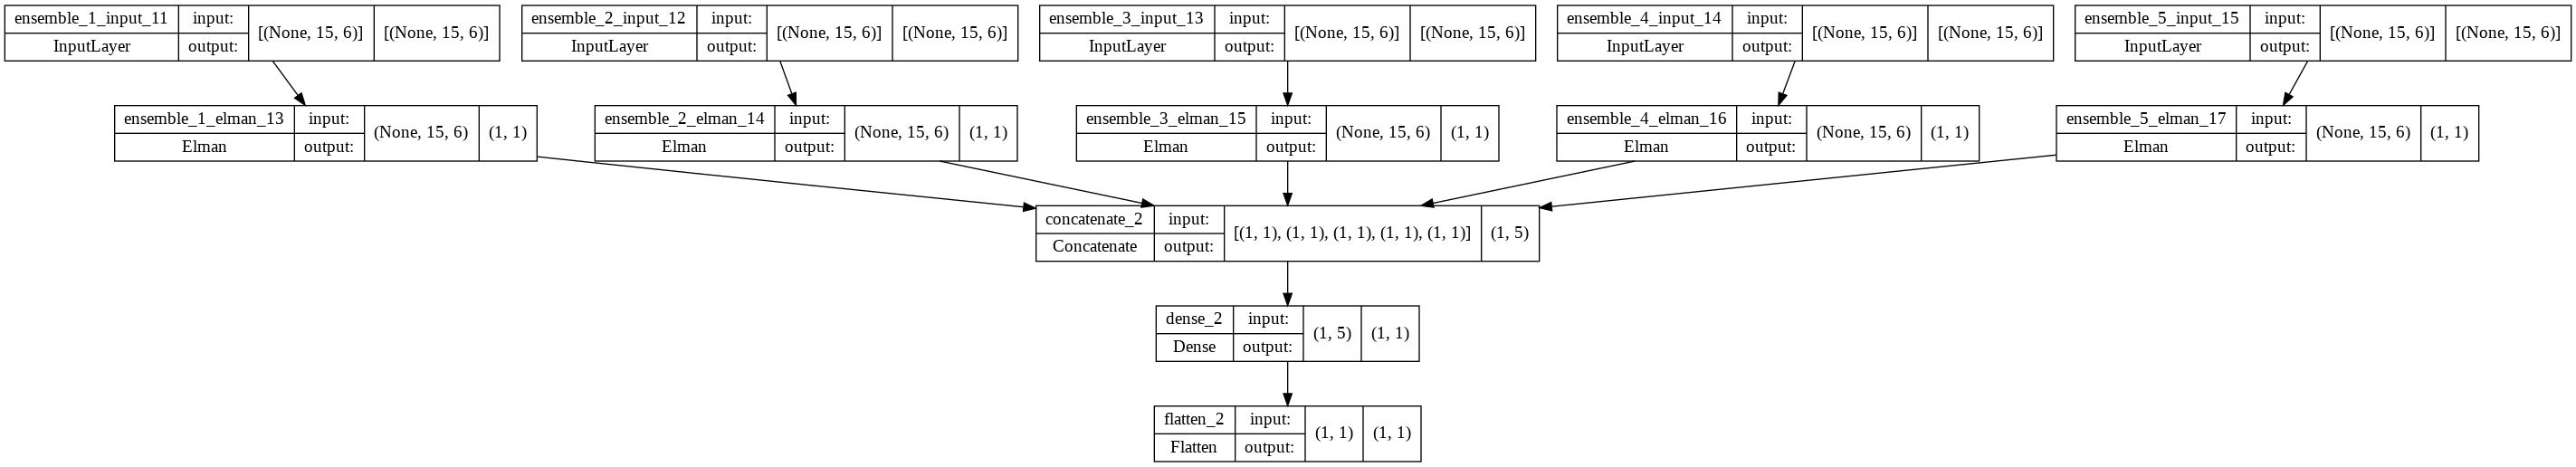

In [79]:
plot_model(ensemble_elman, show_shapes=True, show_layer_names=True, expand_nested=True)

In [80]:
X = [x_train for _ in range(len(ensemble_elman.input))]
val = [x_val for _ in range(len(ensemble_elman.input))]
ensemble_elman.fit(X, y_train, batch_size=1, epochs=100, validation_data=(val, y_val), callbacks=[tb_callback])

Epoch 1/100
323/323 [==============================] - 12s 16ms/step - loss: 0.5984 - accuracy: 0.6563 - val_loss: 0.5188 - val_accuracy: 0.8085
Epoch 2/100
323/323 [==============================] - 4s 11ms/step - loss: 0.5167 - accuracy: 0.6966 - val_loss: 0.4870 - val_accuracy: 0.8085
Epoch 3/100
323/323 [==============================] - 4s 11ms/step - loss: 0.4827 - accuracy: 0.7399 - val_loss: 0.4710 - val_accuracy: 0.6809
Epoch 4/100
323/323 [==============================] - 4s 12ms/step - loss: 0.4500 - accuracy: 0.7554 - val_loss: 0.4679 - val_accuracy: 0.6809
Epoch 5/100
323/323 [==============================] - 4s 11ms/step - loss: 0.4226 - accuracy: 0.7647 - val_loss: 0.4104 - val_accuracy: 0.8085
Epoch 6/100
323/323 [==============================] - 4s 11ms/step - loss: 0.3978 - accuracy: 0.7802 - val_loss: 0.3929 - val_accuracy: 0.8085
Epoch 7/100
323/323 [==============================] - 4s 11ms/step - loss: 0.3791 - accuracy: 0.7988 - val_loss: 0.3878 - val_accuracy

In [81]:
evaluate_ensemble(model=ensemble_elman, x_datas=x_test, y_datas=y_test)

0.956989247311828

In [22]:
# %tensorboard --logdir '/content/drive/MyDrive/logs'

Jordan Ensemble

In [83]:
jordan_models = []
neurons = [15, 25, 35, 45, 55]
for neuron in neurons:
  jordan1 = Jordan(input_dim=15, hidden_units=neuron, feature_size=6, n_classes=1)
  jordan1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  input = tf.keras.Input(shape=(15, 6, ))
  model = Model(input, jordan1(input))
  jordan_models.append(model)

In [84]:
ensemble_jordan = stacked_ensemble(jordan_models)

In [85]:
ensemble_jordan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

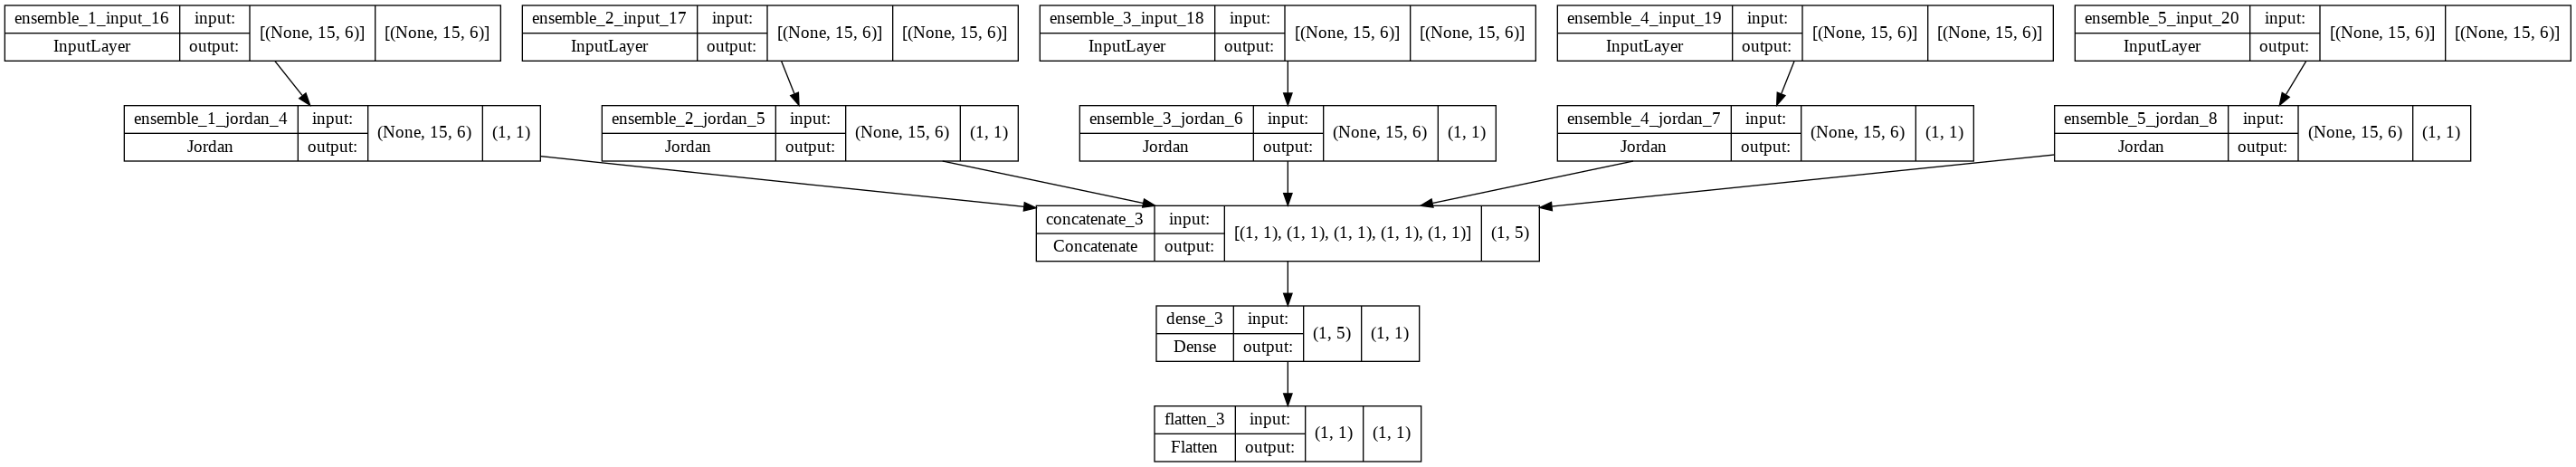

In [86]:
plot_model(ensemble_jordan, show_shapes=True, show_layer_names=True, expand_nested=True)

In [88]:
X = [x_train for _ in range(len(ensemble_jordan.input))]
val = [x_val for _ in range(len(ensemble_jordan.input))]
ensemble_jordan.fit(X, y_train, batch_size=1, epochs=100, validation_data=(val, y_val), callbacks=[tb_callback])

Epoch 1/100
323/323 [==============================] - 16s 23ms/step - loss: 0.5612 - accuracy: 0.7090 - val_loss: 0.4519 - val_accuracy: 0.8085
Epoch 2/100
323/323 [==============================] - 5s 17ms/step - loss: 0.4746 - accuracy: 0.7090 - val_loss: 0.4383 - val_accuracy: 0.8085
Epoch 3/100
323/323 [==============================] - 5s 17ms/step - loss: 0.4261 - accuracy: 0.7368 - val_loss: 0.4420 - val_accuracy: 0.6383
Epoch 4/100
323/323 [==============================] - 5s 17ms/step - loss: 0.3993 - accuracy: 0.7430 - val_loss: 0.4001 - val_accuracy: 0.8085
Epoch 5/100
323/323 [==============================] - 5s 17ms/step - loss: 0.3834 - accuracy: 0.7554 - val_loss: 0.3757 - val_accuracy: 0.8298
Epoch 6/100
323/323 [==============================] - 5s 16ms/step - loss: 0.3931 - accuracy: 0.7337 - val_loss: 0.4361 - val_accuracy: 0.7021
Epoch 7/100
323/323 [==============================] - 5s 16ms/step - loss: 0.3379 - accuracy: 0.8390 - val_loss: 0.3428 - val_accuracy

In [89]:
evaluate_ensemble(model=ensemble_jordan, x_datas=x_test, y_datas=y_test)

0.946236559139785

In [23]:
# %tensorboard --logdir '/content/drive/MyDrive/logs'

## Mixed Ensemble
Best Model

In [157]:
mixed_models = []
neurons = [25, 45, 15]

for neuron in neurons[1:]:
  jordan1 = Jordan(input_dim=15, hidden_units=neuron, feature_size=6, n_classes=1)
  jordan1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  input = tf.keras.Input(shape=(15, 6, ))
  model = Model(input, jordan1(input))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  mixed_models.append(model)

for neuron in neurons[:-1]:
  elman1 = Elman(input_dim=15, hidden_units=neuron, feature_size=6, n_classes=1)
  elman1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  input = tf.keras.Input(shape=(15, 6, ))
  model = Model(input, elman1(input))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  mixed_models.append(model)

In [158]:
ensemble_mixed = stacked_ensemble(mixed_models)

In [159]:
ensemble_mixed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ensemble_mixed.summary()

Model: "model_79"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ensemble_1_input_61 (InputLaye  [(None, 15, 6)]     0           []                               
 r)                                                                                               
                                                                                                  
 ensemble_2_input_62 (InputLaye  [(None, 15, 6)]     0           []                               
 r)                                                                                               
                                                                                                  
 ensemble_3_input_63 (InputLaye  [(None, 15, 6)]     0           []                               
 r)                                                                                        

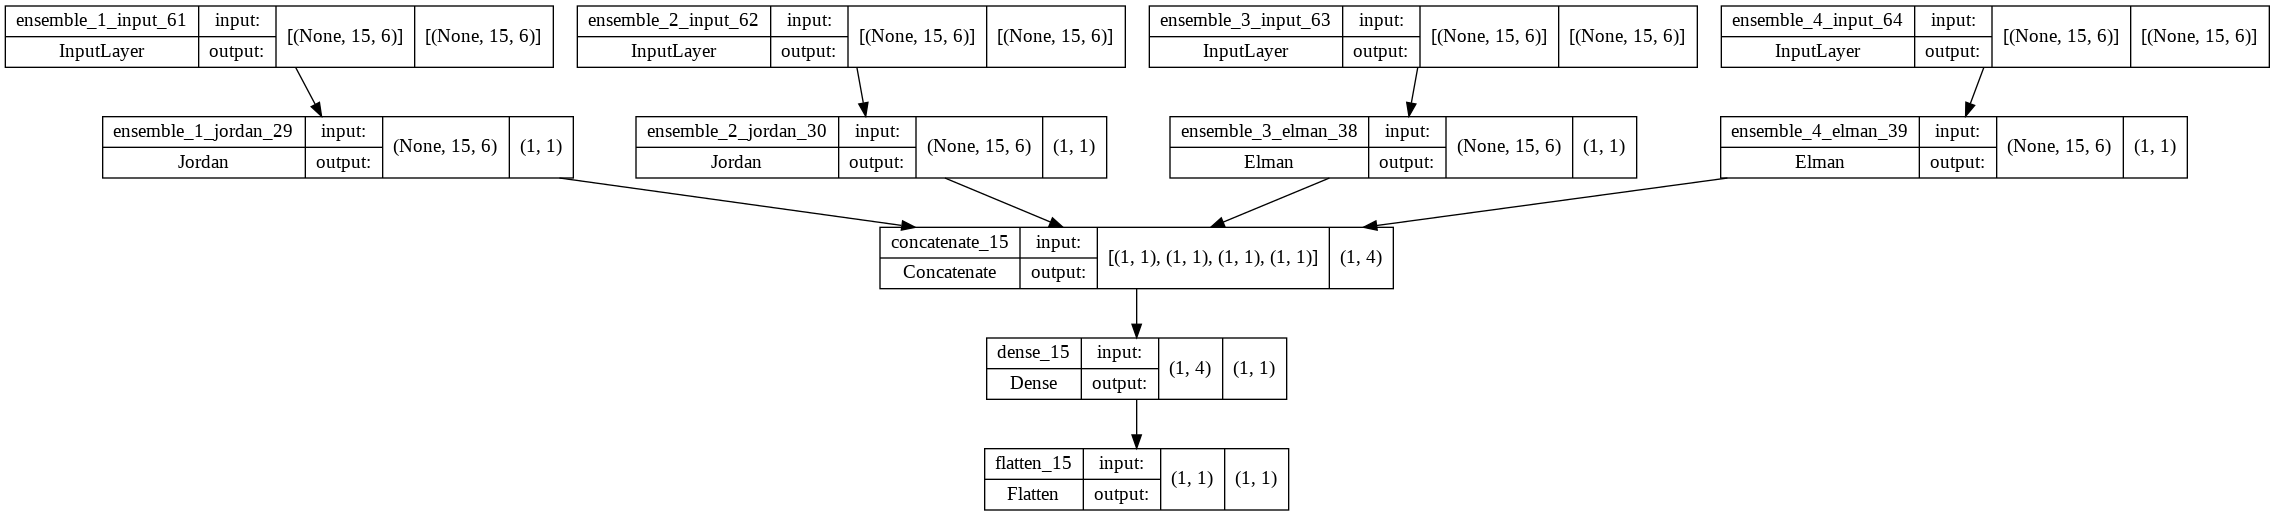

In [160]:
plot_model(ensemble_mixed, show_shapes=True, show_layer_names=True, expand_nested=True)

In [161]:
X = [x_train for _ in range(len(ensemble_mixed.input))]
val = [x_val for _ in range(len(ensemble_mixed.input))]
ensemble_mixed.fit(X, y_train, batch_size=1, epochs=90, validation_data=(val, y_val), callbacks=[tb_callback])

Epoch 1/90
323/323 [==============================] - 9s 16ms/step - loss: 0.5987 - accuracy: 0.7090 - val_loss: 0.5240 - val_accuracy: 0.8085
Epoch 2/90
323/323 [==============================] - 4s 11ms/step - loss: 0.5291 - accuracy: 0.7090 - val_loss: 0.4800 - val_accuracy: 0.8085
Epoch 3/90
323/323 [==============================] - 4s 11ms/step - loss: 0.4918 - accuracy: 0.7090 - val_loss: 0.4464 - val_accuracy: 0.8085
Epoch 4/90
323/323 [==============================] - 4s 12ms/step - loss: 0.4568 - accuracy: 0.7090 - val_loss: 0.4101 - val_accuracy: 0.8085
Epoch 5/90
323/323 [==============================] - 4s 12ms/step - loss: 0.4315 - accuracy: 0.7368 - val_loss: 0.3805 - val_accuracy: 0.8511
Epoch 6/90
323/323 [==============================] - 4s 12ms/step - loss: 0.4096 - accuracy: 0.7740 - val_loss: 0.4164 - val_accuracy: 0.7234
Epoch 7/90
323/323 [==============================] - 4s 12ms/step - loss: 0.3910 - accuracy: 0.7926 - val_loss: 0.3935 - val_accuracy: 0.7234

In [162]:
evaluate_ensemble(model=ensemble_mixed, x_datas=x_test, y_datas=y_test)

0.967741935483871

In [24]:
# %tensorboard --logdir '/content/drive/MyDrive/logs'

## Random Input

In [25]:
def stacked_ensemble(models):
  for i, model in enumerate(models):
    model.trainable = True
    for layer in model.layers:
      layer._name = 'ensemble_' + str(i + 1) + '_' + layer.name

  ensemble_visible = [model.input for model in models]
  ensemble_outputs = [model.output for model in models]
  merge = concatenate(ensemble_outputs)
  output = Dense(1, activation='sigmoid')(merge)
  output = Flatten()(output)
  
  model = Model(inputs=ensemble_visible, outputs=output)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [56]:
def freezer(model, index):
  idx = 0
  model.trainable=True
  for layer in model.layers:
    if 'jordan' in layer.name or 'elman' in layer.name:
      if idx == index:
        layer.trainable = True
        idx += 1

      else:
        layer.trainable = False
        idx += 1
  return model

In [88]:
mixed_models_random_input = []
neurons = [25, 45, 15]

for neuron in neurons[1:]:
  jordan1 = Jordan(input_dim=15, hidden_units=neuron, feature_size=6, n_classes=1)
  jordan1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  input = tf.keras.Input(shape=(15, 6, ))
  model = Model(input, jordan1(input))
  mixed_models_random_input.append(model)

for neuron in neurons[:-1]:
  elman1 = Elman(input_dim=15, hidden_units=neuron, feature_size=6, n_classes=1)
  elman1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  input = tf.keras.Input(shape=(15, 6, ))
  model = Model(input, elman1(input))
  mixed_models_random_input.append(model)

In [89]:
ensemble_mixed_random_input = stacked_ensemble(mixed_models_random_input)

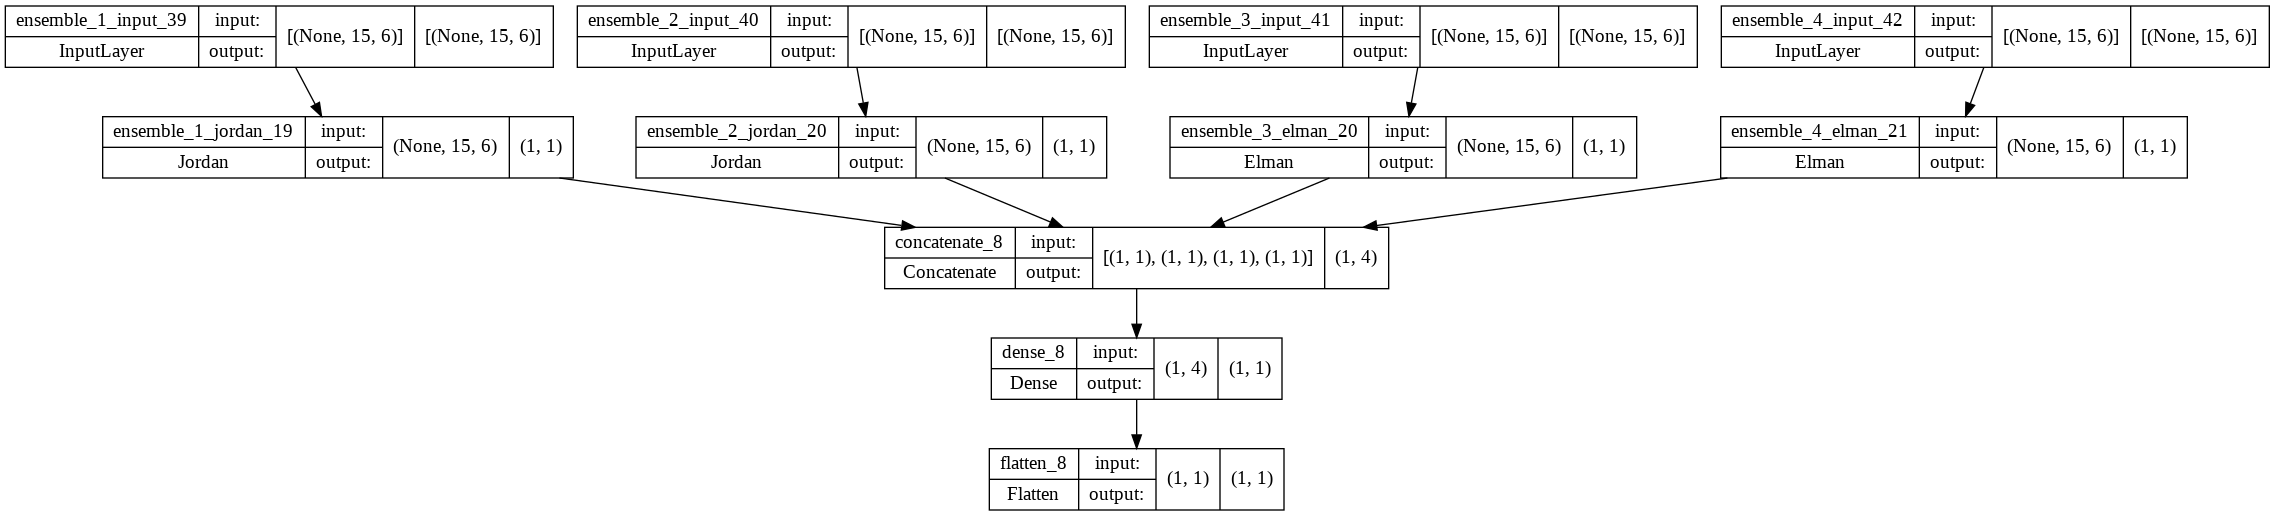

In [90]:
plot_model(ensemble_mixed_random_input, show_shapes=True, show_layer_names=True, expand_nested=True)

In [76]:
x_train.shape

(323, 15, 6)

In [77]:
models_cnt = len(ensemble_mixed_random_input.input)
diff = models_cnt + 1 - np.mod(x_train.shape[0], models_cnt + 1)
x_train_agu = np.append(x_train, [x_train[i] for i in range(diff)], axis=0) # add some data to have a equal chunks = here we have 323 datas which needs to add 1 data -> 324 mod 4 = 0

y_train_agu = y_train.copy()
for i in range(diff):
  y_train_agu = np.append(y_train_agu, y_train[i])

x_train_chunks = np.array(np.array_split(x_train_agu, models_cnt + 1))
y_train_chunks = np.array_split(y_train_agu, models_cnt + 1)

In [78]:
x_train_agu.shape

(325, 15, 6)

In [79]:
x_train_chunks.shape

(5, 65, 15, 6)

In [80]:
ensemble_mixed_random_input.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
X = [x_train_chunks[0] for _ in range(models_cnt)]
val = [x_val for _ in range(models_cnt)]
ensemble_mixed_random_input.fit(X, y_train_chunks[0], batch_size=1, epochs=30, validation_data=(val, y_val), callbacks=[tb_callback])

for i, x_chunk, y_chunk in zip(range(models_cnt), x_train_chunks[1:], y_train_chunks[1:]):
  model = freezer(ensemble_mixed_random_input, i)
  model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])

  X = [x_chunk for _ in range(models_cnt)]
  val = [x_val for _ in range(models_cnt)]

  model.fit(X, y_chunk, batch_size=1, epochs=50, validation_data=(val, y_val), callbacks=[tb_callback])

Epoch 1/30
65/65 [==============================] - 7s 28ms/step - loss: 0.5904 - accuracy: 0.7077 - val_loss: 0.4598 - val_accuracy: 0.8085
Epoch 2/30
65/65 [==============================] - 0s 7ms/step - loss: 0.5054 - accuracy: 0.7077 - val_loss: 0.4283 - val_accuracy: 0.8085
Epoch 3/30
65/65 [==============================] - 0s 6ms/step - loss: 0.4771 - accuracy: 0.7077 - val_loss: 0.4140 - val_accuracy: 0.8085
Epoch 4/30
65/65 [==============================] - 0s 7ms/step - loss: 0.4454 - accuracy: 0.6769 - val_loss: 0.4506 - val_accuracy: 0.6383
Epoch 5/30
65/65 [==============================] - 0s 7ms/step - loss: 0.4387 - accuracy: 0.6615 - val_loss: 0.4216 - val_accuracy: 0.7021
Epoch 6/30
65/65 [==============================] - 0s 6ms/step - loss: 0.4194 - accuracy: 0.7385 - val_loss: 0.3904 - val_accuracy: 0.8723
Epoch 7/30
65/65 [==============================] - 0s 6ms/step - loss: 0.4030 - accuracy: 0.7692 - val_loss: 0.4026 - val_accuracy: 0.7021
Epoch 8/30
65/65 [=

In [81]:
evaluate_ensemble(model=model, x_datas=x_test, y_datas=y_test)

0.8494623655913979

## Increasing number of sub-networks

In [107]:
mixed_models_random_input = []
neurons = [25, 35, 55, 45, 25, 15]

for neuron in neurons[3:]:
  jordan1 = Jordan(input_dim=15, hidden_units=neuron, feature_size=6, n_classes=1)
  jordan1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  input = tf.keras.Input(shape=(15, 6, ))
  model = Model(input, jordan1(input))
  mixed_models_random_input.append(model)

for neuron in neurons[:-2]:
  elman1 = Elman(input_dim=15, hidden_units=neuron, feature_size=6, n_classes=1)
  elman1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  input = tf.keras.Input(shape=(15, 6, ))
  model = Model(input, elman1(input))
  mixed_models_random_input.append(model)

In [108]:
ensemble_mixed_random_input = stacked_ensemble(mixed_models_random_input)

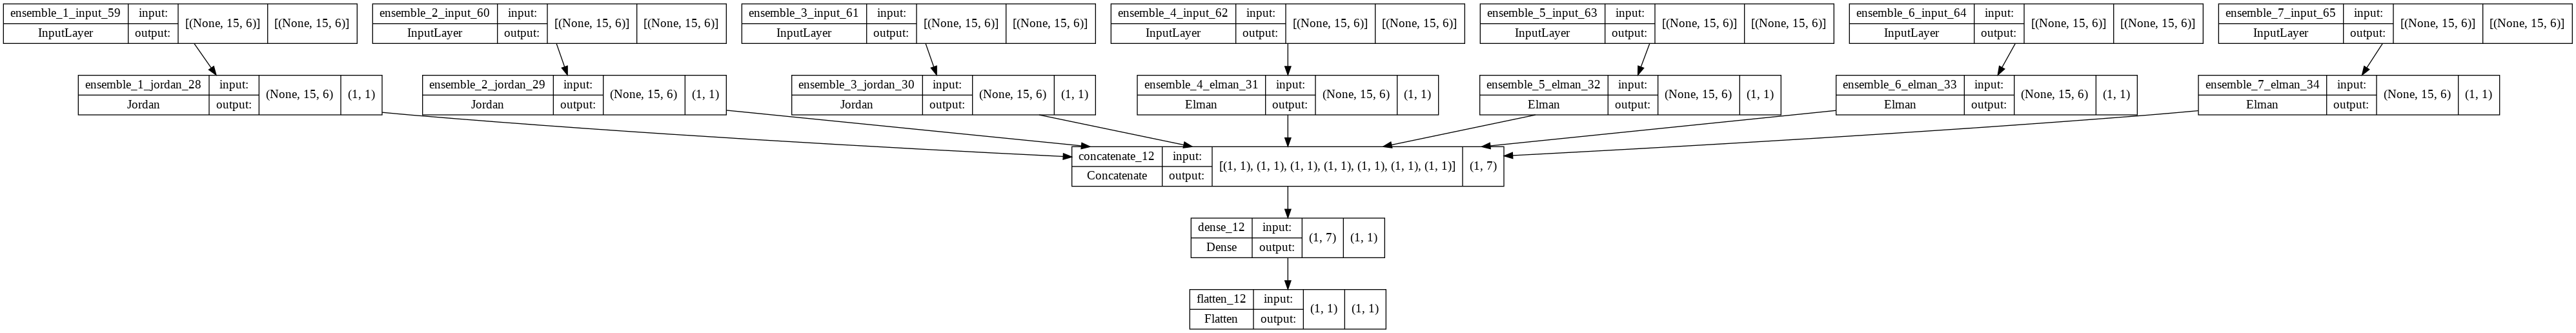

In [109]:
plot_model(ensemble_mixed_random_input, show_shapes=True, show_layer_names=True, expand_nested=True)

In [110]:
models_cnt = len(ensemble_mixed_random_input.input)
diff = models_cnt + 1 - np.mod(x_train.shape[0], models_cnt + 1)
x_train_agu = np.append(x_train, [x_train[i] for i in range(diff)], axis=0) # add some data to have a equal chunks = here we have 323 datas which needs to add 1 data -> 324 mod 4 = 0

y_train_agu = y_train.copy()
for i in range(diff):
  y_train_agu = np.append(y_train_agu, y_train[i])

x_train_chunks = np.array(np.array_split(x_train_agu, models_cnt + 1))
y_train_chunks = np.array_split(y_train_agu, models_cnt + 1)

In [111]:
ensemble_mixed_random_input.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
X = [x_train_chunks[0] for _ in range(models_cnt)]
val = [x_val for _ in range(models_cnt)]
ensemble_mixed_random_input.fit(X, y_train_chunks[0], batch_size=1, epochs=30, validation_data=(val, y_val), callbacks=[tb_callback])

for i, x_chunk, y_chunk in zip(range(models_cnt), x_train_chunks[1:], y_train_chunks[1:]):
  model = freezer(ensemble_mixed_random_input, i)
  model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])

  X = [x_chunk for _ in range(models_cnt)]
  val = [x_val for _ in range(models_cnt)]

  model.fit(X, y_chunk, batch_size=1, epochs=50, validation_data=(val, y_val), callbacks=[tb_callback])

Epoch 1/30
41/41 [==============================] - 11s 113ms/step - loss: 0.6119 - accuracy: 0.6829 - val_loss: 0.4527 - val_accuracy: 0.8085
Epoch 2/30
41/41 [==============================] - 0s 11ms/step - loss: 0.4898 - accuracy: 0.5854 - val_loss: 0.4206 - val_accuracy: 0.6383
Epoch 3/30
41/41 [==============================] - 0s 12ms/step - loss: 0.4708 - accuracy: 0.5610 - val_loss: 0.4313 - val_accuracy: 0.6383
Epoch 4/30
41/41 [==============================] - 0s 11ms/step - loss: 0.4396 - accuracy: 0.7073 - val_loss: 0.4442 - val_accuracy: 0.6596
Epoch 5/30
41/41 [==============================] - 1s 12ms/step - loss: 0.4286 - accuracy: 0.6585 - val_loss: 0.4418 - val_accuracy: 0.6596
Epoch 6/30
41/41 [==============================] - 1s 12ms/step - loss: 0.4199 - accuracy: 0.7317 - val_loss: 0.4574 - val_accuracy: 0.6383
Epoch 7/30
41/41 [==============================] - 1s 12ms/step - loss: 0.4212 - accuracy: 0.6341 - val_loss: 0.4667 - val_accuracy: 0.6170
Epoch 8/30


In [112]:
evaluate_ensemble(model=model, x_datas=x_test, y_datas=y_test)

0.7311827956989247

Which neurons = [25, 45, 25]

> Elman = neurons[:-1]

> Jordan = neurons[1:]

were the best model with accuracy of 85%